In [29]:
import numpy as np
import matplotlib.pyplot as plt
import csv, datetime
import pandas as pd
import os
from sklearn.metrics import r2_score


def MakeDataFromText(filepath):
    """
    Helper function to parse text files in IFM proprietary format.
    """
    with open(filepath, 'r') as file:
        reader = csv.reader(file)

        db = dict()                          # Dictionary that will hold k,v pairs of 
        recent_EPC = ''                      # The most recent EPC that was read, and data is being assigned to
        Time_Or_Data = True                  # Time is true, Data is false
        reached_24 = False

        for l in reader:                     # Iterate over entire text file
            line = l[0]                      # Each line only has one token, so we select it
            
            if len(line)==24:                # If it is an EPC
                db[line] = [[],[]]           # Create new k,v pair in database
                recent_EPC = line            # Current EPC to add to is selected
            
            elif line == '[':                # If start bracket, beginning to collect an array of data
                data = []

            elif line == ']':                # End bracket means end of data array
                if len(data)!=0:
                    if Time_Or_Data:
                        db[recent_EPC][0] = data
                        Time_Or_Data = False
                    else:
                        db[recent_EPC][1] = data
                        Time_Or_Data = True
                data = []

            elif line.count(":")==2:
                h,m,s = line.split(':')      # Parse timestamp into hours, minutes, seconds

                if int(h)==23:
                    reached_24 = True        # If end of day reached, must move to Day 2

                if reached_24 and int(h) < 12:
                    day=2
                else:
                    day=1

                data.append(datetime.datetime(1970, 2, day, int(h), int(m), int(s)))
            
            elif line ==' ':               # If blank space, then we skip to parse next line
                pass

            else:                          # If it is a data point
                try:
                    data.append(float(line))
                except:
                    pass                   # Error catching case just in case, so annoying errors don't crash program
    return db

In [30]:
rrr = MakeDataFromText("032423 test on 40C water/RSSI_92130.csv")
ttt = MakeDataFromText("032423 test on 40C water/tags_92130.csv")

temp = dict()
for d in [ ttt ]:
    for k,v in d.items():
        if k in temp: # if tag is already in dict
            for i in range(len(v[0])):
                if v[0][i] in temp[k]:
                    temp[k][v[0][i]].append(v[1][i])
                else:
                    temp[k][v[0][i]] = [v[1][i]]
        else:             # if tag is not in dict
            temp[k] = dict()
            for i in range(len(v[0])):
                temp[k][v[0][i]] = [v[1][i]]
for k,v in temp.items():
    for k2,v2 in v.items():
        temp[k][k2] = sum(v2)/len(v2)

rssi = dict()
for d in [ rrr ]:
    for k,v in d.items():
        if k in rssi: # if tag is already in dict
            for i in range(len(v[0])):
                if v[0][i] in rssi[k]:
                    rssi[k][v[0][i]].append(v[1][i])
                else:
                    rssi[k][v[0][i]] = [v[1][i]]
        else:             # if tag is not in dict
            rssi[k] = dict()
            for i in range(len(v[0])):
                rssi[k][v[0][i]] = [v[1][i]]
for k,v in rssi.items():
    for k2,v2 in v.items():
        rssi[k][k2] = sum(v2)/len(v2)

In [31]:
data = { i:[] for i in range(26) }

for k,v in temp.items():
    if k[-4:]=="2B1C":
        st = sorted( temp[k].items() )
        sr = sorted( rssi[k].items() )

dt, tt = [ j[1] for j in st ], [ j[0] for j in st ]
dr, tr = [ j[1] for j in sr ], [ j[0] for j in sr ]

for i in range(len(dt)):
    data[dr[i]].append(dt[i])

Text(0.5, 0, 'RSSI (dBm)')

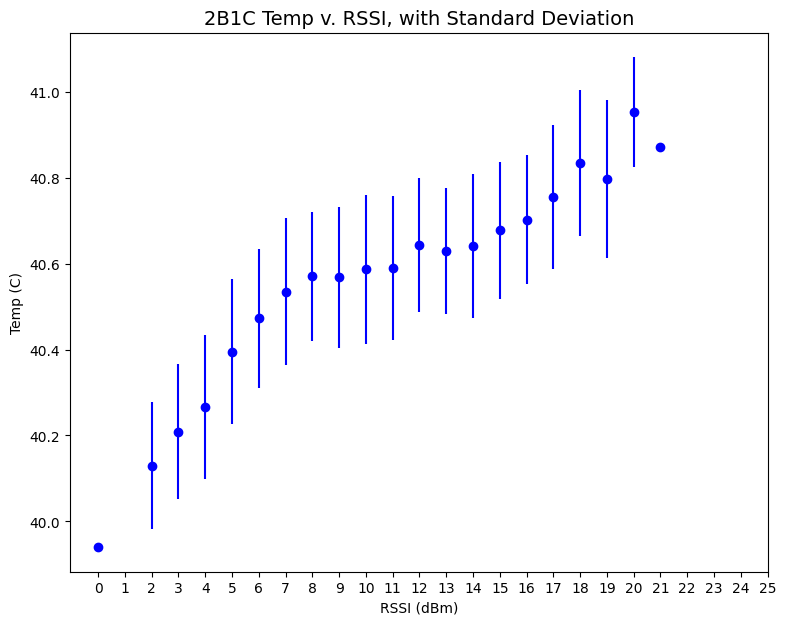

In [36]:
fig,ax = plt.subplots(1, 1, figsize=(9,7))

for k,v in data.items():
    if len(v)>0:
        mean = sum(v)/len(v)
        std = np.std(v)

        ax.scatter(k, mean, marker='o',color='b')
        ax.errorbar(k, mean, yerr=std, color='b')

ax.set_xticks(range(26))
ax.set_title("2B1C Temp v. RSSI, with Standard Deviation", fontsize=14)
ax.set_ylabel("Temp (C)")
ax.set_xlabel("RSSI (dBm)")